In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kruskal
import scikit_posthocs as sp

In [86]:
df_all=pd.read_csv('../../data/antiviral_homology_90.csv')

In [87]:
df_all

,sequence,experimental_characteristics,half_life_seconds,length_sequence,target
0,AAAMSQVTN,Mammalian,15840.0,9,1
1,AACEVAKNLNESLIDLQELGKYEQYIKW,Mammalian,15840.0,28,1
2,AAGAVVNDL,Mammalian,15840.0,9,1
3,AAHLIDALYAEFLGGRVLTTPVVHRALFYASAVLRQPFLAGVPSA,Mammalian,15840.0,45,1
4,AAKAWKKAKAWKKAKWWKKAA,Mammalian,15840.0,21,1
...,...,...,...,...,...
1308,YVREHGVPIHADKYFEQVLK,Mammalian,10080.0,20,1
1309,YWILEYLWKVPFDFWRGV,E_coli,7200.0,18,0
1310,YWILEYLWKVPFDFWRGV,Mammalian,10080.0,18,1
1311,YWILEYLWKVPFDFWRGV,Yeast,36000.0,18,2


In [88]:
df_all=df_all.filter(items=['sequence', 'half_life_seconds', 'target'])

In [89]:
df_all['length']=df_all['sequence'].apply(len)

In [90]:
df_h=df_all[df_all['target']==2]
df_m=df_all[df_all['target']==1]
df_l=df_all[df_all['target']==0]

In [91]:
corr_all = df_all['length'].corr(df_all['half_life_seconds'])
corr1 = df_h['length'].corr(df_h['half_life_seconds'])
corr2= df_m['length'].corr(df_m['half_life_seconds'])
corr3= df_l['length'].corr(df_l['half_life_seconds'])

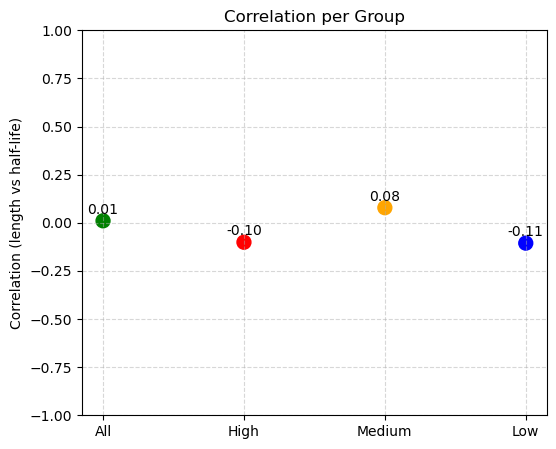

In [92]:
corr_values = [corr_all, corr1, corr2, corr3]
groups = ['All', 'High', 'Medium', 'Low']

# Crear scatter plot de solo 3 puntos
plt.figure(figsize=(6, 5))
plt.scatter(groups, corr_values, color=['green', 'red', 'orange', 'blue'], s=100)

# Agregar etiquetas
for i, value in enumerate(corr_values):
    plt.text(groups[i], value + 0.02, f"{value:.2f}", ha='center', va='bottom', fontsize=10)

plt.ylim(-1, 1)  # Porque las correlaciones están entre -1 y 1
plt.ylabel('Correlation (length vs half-life)')
plt.title('Correlation per Group')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(f"../../img/antiviral/stat/correlation_length.png", dpi=300)
plt.show()


In [93]:
df_m

,sequence,half_life_seconds,target,length
0,AAAMSQVTN,15840.0,1,9
1,AACEVAKNLNESLIDLQELGKYEQYIKW,15840.0,1,28
2,AAGAVVNDL,15840.0,1,9
3,AAHLIDALYAEFLGGRVLTTPVVHRALFYASAVLRQPFLAGVPSA,15840.0,1,45
4,AAKAWKKAKAWKKAKWWKKAA,15840.0,1,21
...,...,...,...,...
1297,YRWWRWARRWYRWWRWARRW,10080.0,1,20
1300,YTMLVVDDL,10080.0,1,9
1303,YTSLIHSLIEEAQNQQEKNEQELLELDKWASLWNWF,10080.0,1,36
1308,YVREHGVPIHADKYFEQVLK,10080.0,1,20


In [94]:
n_iterations = 1000
n_samples = min(len(df_h), len(df_m), len(df_l)) 
i=0
results_list = []
post_hoc_results_list = []

In [96]:
for i in range(n_iterations):
    high_sample = df_h.sample(n=n_samples, replace=False, random_state=i)
    mid_sample = df_m.sample(n=n_samples, replace=False, random_state=i)
    low_sample = df_l.sample(n=n_samples, replace=False, random_state=i)
    
    stat, p_value = kruskal(high_sample['length'], mid_sample['length'], low_sample['length'])
        
    results_list.append({
        'Iteration': i, 'P_value': p_value
    })
        
    if p_value < 0.05:
        combined_samples = [high_sample['length'], mid_sample['length'], low_sample['length']]
        pvals_dunn = sp.posthoc_dunn(combined_samples, p_adjust='bonferroni')
        
        dunn_results = pvals_dunn.to_dict()  #Convertir el DataFrame de Dunn en un diccionario
        dunn_results = {
            'High_vs_Mid': pvals_dunn.iloc[2, 1],
            'High_vs_Low': pvals_dunn.iloc[2, 0],
            'Mid_vs_Low': pvals_dunn.iloc[1, 0]
        }

        post_hoc_results_list.append({
            'Iteration': i, 'PostHoc_Pvalues': dunn_results
        })

results = pd.DataFrame(results_list)
dunn = pd.DataFrame(post_hoc_results_list)

In [97]:
results

,Iteration,P_value
0,0,0.003116
1,1,0.028443
2,2,0.015713
3,3,0.121116
4,4,0.089234
...,...,...
995,995,0.133724
996,996,0.052610
997,997,0.024747
998,998,0.198836


In [98]:
results.mean()

Iteration    499.50000
P_value        0.03173
dtype: float64